In [1]:
import random
import numpy as np
import scipy.sparse as sp
import scipy.sparse.csgraph
from scipy.sparse import csr_matrix,issparse
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, IterableDataset, get_worker_info
from sklearn.datasets import make_swiss_roll,make_s_curve
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state
from sklearn.neighbors import kneighbors_graph,radius_neighbors_graph
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.preprocessing import StandardScaler,MinMaxScaler

import sys
sys.path.append('..')

from utils.g2g_model_Fisher import *
from utils.utils import *
from utils.RKHS import *
from sklearn.preprocessing import MinMaxScaler

In [2]:
model_name = 'bifurcation'
result_path = 'results/'+model_name+'/'
figure_path = 'figures/'
cmap = plt.colormaps['Spectral_r']

In [3]:
import os

folder = os.path.exists(result_path)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(result_path)
folder = os.path.exists(figure_path)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(figure_path) 

In [4]:
# Define the parameters of the simulation
k1 = 0.05
k2= -0.06
k3= -1.0

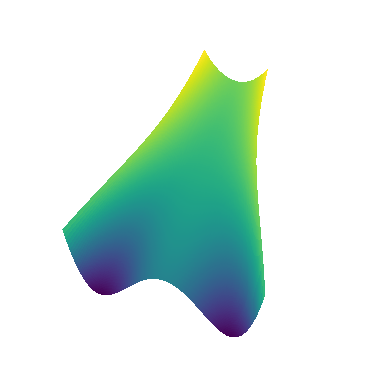

In [5]:
#### import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the double well potential function
def bifur_potential(x, y):
    return k1*x**4 + k2*y*x**2 + k3*y

# Define the range of x and y values to plot

#x = np.linspace(-7, 7, 100)
#y = np.linspace(-10, 40, 100)

# Create a 2D grid of x and y values
#X0, Y0 = np.meshgrid(x, y)

nx = 1000
ny = 1000
ym = 200

Y0 = np.outer(np.linspace(-150, 150, ny),np.ones(nx))
X0 = np.zeros([ny,nx])
for i in range(ny):
    xm0 = -k2*Y0[i,0]/k1/2
    xm = np.sqrt(xm0+np.sqrt(xm0**2+ym/k1))
    X0[i] = np.linspace(-xm, xm, nx)

# Calculate the potential energy at each point in the grid
Z0 = bifur_potential(X0, Y0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X0, Y0, Z0, cmap='viridis', linewidth=0, antialiased=False, rcount=200, ccount=200)
#ax.plot_surface(X0, Y0, Z0, facecolors=plt.cm.viridis(Z0-k3*Y0), linewidth=0, antialiased=False)

ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.set_xlabel('X',fontsize=20,weight='bold')
ax.set_ylabel('Y',fontsize=20,weight='bold')
ax.set_zlabel('Z',fontsize=20,weight='bold')
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])
plt.axis('off')

ax.view_init(60, 110)
plt.savefig(figure_path+'bifur_potential.png',dpi=600,bbox_inches='tight')
plt.show()

In [6]:
# Define the double well potential
def potential(x,k1,k2,k3):
    return k1*x[0]**4 + k2*(x[1])*x[0]**2 + k3*(x[1])

k1 = 0.05
k2= -0.06
k3= -1.0

# Define the gradient of the potential
def gradient(x,k1,k2,k3):
    return np.array([4.0*k1*x[0]**3+2.0*k2*(x[1])*x[0],k2*x[0]**2+k3])

# Define the stochastic force
def stochastic_force(x,D):
    return 1.0*np.sqrt(2.0 * D) * np.random.normal(size=2)

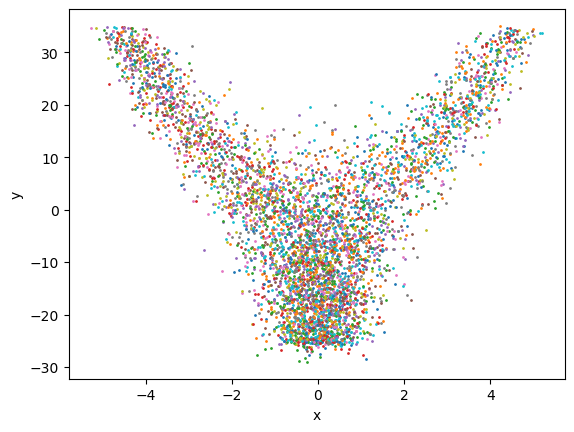

In [7]:
D = 1 # Temperature
dt = 0.01  # Time step
tmax = 100.0  # Maximum simulation time


step=100

trajs=[]
traj_vs=[]
traj_m2s=[]
x0=(np.random.rand(100,2)-0.5)*1
x0[:,1]-=25
# print(x0)
# x0=np.array([[0.,-40.]])
for tl in range(100):
    # Perform the simulation using the Euler-Maruyama method
    
    x = x0[tl,:].copy()
    v = np.zeros(2)
    t = np.arange(0.0, tmax, dt)
    
    tr = np.zeros((len(t), 2))
    tr[0] = x
    
    tr_U= np.zeros((len(t), 1))
    tr_U[0]=potential(x,k1,k2,k3)
    
    tr_v= np.zeros((len(t), 2))
    tr_v[0]=v
    
    tr_Uv= np.zeros((len(t), 1))
    tr_Uv[0]=0
    
    tr_m2=np.zeros((len(t),2))

    i=0
    while (i<len(t) and np.abs(x[1])<35):
        # Calculate the deterministic force
        f_d = -gradient(x,k1,k2,k3)

        # Calculate the stochastic force
        f_s = stochastic_force(x,D)

        # Calculate the position using the Euler method
        x += (f_d*dt + f_s*np.sqrt(dt))

        # Update the trajectory array
        tr[i] = x
        tr_U[i] = potential(x,k1,k2,k3)
        tr_v[i]=f_d
        tr_Uv[i]=(tr_U[i]-tr_U[i-1])/dt
        
        i+=1

#     trajs.append(tr[::200,:])
    trajs.append(np.hstack((tr[::step, :],tr_U[::step,:])))
    traj_vs.append(np.hstack((tr_v[::step, :],tr_Uv[::step,:])))
    traj_m2s.append(tr_m2)
    # Plot the trajectory of the particle
    plt.scatter(tr[::step, 0], tr[::step, 1],s=1)
    plt.xlabel('x')
    plt.ylabel('y')
    # plt.axis('equal')
    # plt.title('Trajectory of Particle in Double Well Potential')
plt.show()

In [8]:
X_ori=np.concatenate(trajs,axis=0)
_,inds=np.unique(X_ori[:,0],return_index=True)
X_major=X_ori[inds,:]
scaler=StandardScaler()#MinMaxScaler()#
X_major=scaler.fit_transform(X_major)

In [9]:
n_samples=X_major.shape[0]

X_minor=0.1*np.random.randn(n_samples,7)

X=np.hstack((X_major,X_minor))

color_label=np.zeros((n_samples,))
color_label[np.argsort(X[:,0])]=np.arange(n_samples)
print(X.shape)

(4833, 10)


In [10]:
X0 = X
X = X[::2]
color_label = color_label[::2]
n_samples = X.shape[0]

In [11]:
k_nei = 10
A = kneighbors_graph(X, k_nei, mode='connectivity', include_self=True)

In [12]:
row = np.array([np.ones((k_nei,))*i for i in range(X.shape[0])]).flatten()
col = np.array([np.where(A.getrow(i).toarray()[0,:])[0] for i in range(X.shape[0])]).flatten()
w_val = np.array([np.linalg.norm(X[int(i),:]-X[int(j),:]) for i,j in zip(row,col)])
adj_val = np.ones(col.shape)
A_mat = csr_matrix((adj_val, (row, col)), shape=(X.shape[0], X.shape[0]))
W_mat = csr_matrix((w_val, (row, col)), shape=(X.shape[0], X.shape[0]))

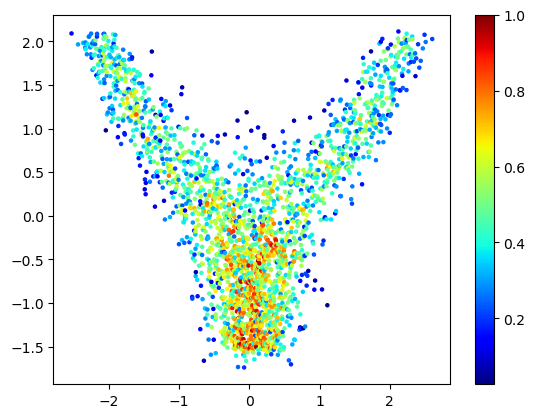

In [13]:
dc=np.mean(w_val)

cell_nei=A.indices.reshape(n_samples,k_nei).copy().copy().astype(np.int32)#np.array([np.where(A.getrow(i).toarray()[0,:])[0] for i in range(X.shape[0])]).astype(np.int32)
nei_w=[]
rho_arr=[]
for ni in cell_nei:
    dij=np.array([np.linalg.norm(X[int(ni[0]),:]-X[int(i),:]) for i in ni[1:]])
    
    rho=np.sum(np.exp(-dij**2/dc**2))
#     rho=np.exp(np.sum(-dij**2/dc**2))
    nei_w.append(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
#     print(dij)
#     print(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
    rho_arr.append(rho)
rho_arr=np.array(rho_arr)/np.amax(rho_arr)
nei_w=np.array(nei_w)
nei_w=np.hstack((np.ones((nei_w.shape[0],1)),nei_w))/2

plt.scatter(X[:,0],X[:,1],s=5,c=rho_arr,cmap=plt.cm.jet)
plt.colorbar()
plt.show()

In [14]:
def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return X_s

In [15]:
epochs = 200
nsamples = 5
learning_rate = 1e-3
seed = 1950
n_workers = 0
K = 3
#     checkpoint_path = args.checkpoint
#     checkpoints_path = args.checkpoints
#     dataset_path = args.dataset

if seed is not None:
    reset_seeds(seed)

A=A.astype(np.float32)
X=X.astype(np.float32)
z=color_label

n = A.shape[0]
train_nodes, val_nodes = train_test_split(n, train_ratio=1)
A_train = A[train_nodes, :][:, train_nodes]
X_train = X[train_nodes]
z_train = z[train_nodes]
A_val = A[val_nodes, :][:, val_nodes]
X_val = X[val_nodes]
z_val = z[val_nodes]

train_data = AttributedGraph(A_train, X_train, z_train, K)
val_data = AttributedGraph(A_val, X_val, z_val, K)

L = 3
encoder = Encoder(X.shape[1], L)

In [16]:
optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)

iterations = 200#epochs // n_workers
dataset = GraphDataset(train_data, nsamples, iterations)
loader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=n_workers,
    worker_init_fn=reset_seeds,
    collate_fn=lambda args: args,
)

In [17]:
for batch_idx, data in enumerate(loader):
    encoder.train()
    optimizer.zero_grad()

    loss = encoder.compute_loss(data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5])
    if batch_idx% 10 == 0:
        print(batch_idx,loss)
    loss.backward()
    optimizer.step()

0 tensor(4.5494e+08, grad_fn=<DivBackward0>)
10 tensor(2.2076e+08, grad_fn=<DivBackward0>)
20 tensor(2.0563e+08, grad_fn=<DivBackward0>)
30 tensor(2.0142e+08, grad_fn=<DivBackward0>)
40 tensor(1.9863e+08, grad_fn=<DivBackward0>)
50 tensor(1.9799e+08, grad_fn=<DivBackward0>)
60 tensor(1.9529e+08, grad_fn=<DivBackward0>)
70 tensor(1.9678e+08, grad_fn=<DivBackward0>)
80 tensor(1.9436e+08, grad_fn=<DivBackward0>)
90 tensor(1.9289e+08, grad_fn=<DivBackward0>)
100 tensor(1.9333e+08, grad_fn=<DivBackward0>)
110 tensor(1.9162e+08, grad_fn=<DivBackward0>)
120 tensor(1.9239e+08, grad_fn=<DivBackward0>)
130 tensor(1.9372e+08, grad_fn=<DivBackward0>)
140 tensor(1.9213e+08, grad_fn=<DivBackward0>)
150 tensor(1.9408e+08, grad_fn=<DivBackward0>)
160 tensor(1.9324e+08, grad_fn=<DivBackward0>)
170 tensor(1.9455e+08, grad_fn=<DivBackward0>)
180 tensor(1.9361e+08, grad_fn=<DivBackward0>)
190 tensor(1.9299e+08, grad_fn=<DivBackward0>)


In [18]:
z = train_data.z
mu, sigma = encoder(train_data.X)
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()

In [19]:
sort_idx = z.argsort()

match_idx=sort_idx[np.searchsorted(z,color_label,sorter = sort_idx)]
print(match_idx)

[1893  445  292 ... 1118  711  834]


In [20]:
X_mu = mu_learned[match_idx]
X_sigma = sigma_learned[match_idx]
X_label = z[match_idx]

In [21]:
latent_z=[]
for i in range(X_mu.shape[1]):
    latent_z.append(X_mu[:,i])
    latent_z.append(X_sigma[:,i])
latent_z=np.array(latent_z).T
latent_z.shape

(2417, 6)

In [22]:
Fisher_g=np.zeros((X_mu.shape[0],L*2,L*2))
for i in range(X_mu.shape[0]):
    for j in range(L):
        Fisher_g[i,2*j,2*j]=1/(X_sigma[i,j]**2)
        Fisher_g[i,2*j+1,2*j+1]=2/(X_sigma[i,j]**2)

In [23]:
def Fisher_dist(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dF2=0
    for i in range(dim):
        a=np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]+sigma2[i])**2)+\
          np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]-sigma2[i])**2)
        b=np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]+sigma2[i])**2)-\
          np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]-sigma2[i])**2)
        
        dF2+=2*(np.log(a/b))**2
    dF=np.sqrt(dF2)
    return dF

In [24]:
def wasserstein_distance(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dmu=mu1-mu2
    W_dist2=0
    for i in range(dim):
        W_dist2+=dmu[i]**2+sigma1[i]**2+sigma2[i]**2-2*np.sqrt(sigma2[i]*sigma1[i]**2*sigma2[i])
    W_dist=np.sqrt(W_dist2)
    return W_dist

In [25]:
cRc_arr=[]
for inds in cell_nei:#np.split(A.indices, A.indptr)[1:-1]:

    self_ind=inds[0]
    cRc=0
    for nei_k in range(1,len(inds)):
        
        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
        #dFi=Fisher_dist(X_mu[self_ind,:],X_sigma[self_ind,:],\
        #                X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:])
        dWa=wasserstein_distance(X_mu[self_ind,:],X_sigma[self_ind,:],\
                        X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:])
        
        cRc+=(1-dWa/dEu)
    
    cRc_arr.append(cRc/len(inds))
#     cRc_arr.append(cRc)
cRc_arr = np.array(cRc_arr)
cRc_smooth = smooth_func(cRc_arr)

In [26]:
X_plt = X[:,0]
Y_plt = -X[:,1]
#X_plt = mu_learned[:,0]
#Y_plt = sigma_learned[:,1]
X_min = np.min(X_plt)
X_max = np.max(X_plt)
Y_min = np.min(Y_plt)
Y_max = np.max(Y_plt)
X_len = (X_max-X_min)/5
Y_len = (Y_max-Y_min)/5
wid = min(X_len,Y_len)/30
X_ori = X_min-wid*10
Y_ori = Y_min-wid*10

import os

folder = os.path.exists(figure_path)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(figure_path) 

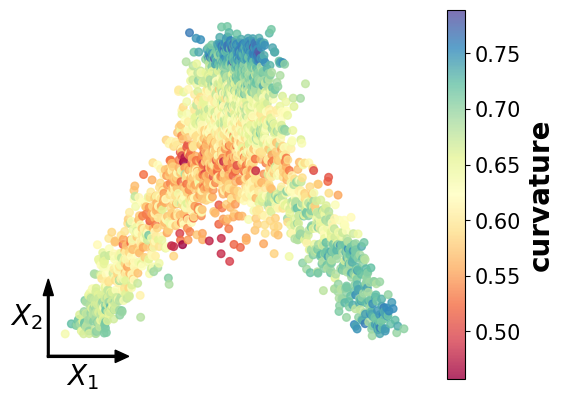

In [27]:
plt.scatter(X_plt,Y_plt,s=30,alpha=0.8,c=cRc_smooth,cmap=plt.colormaps['Spectral'])
plt.axis('off')

plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=6*wid,head_length=8*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=6*wid,head_length=8*wid)
plt.text(X_ori+X_len/2,Y_ori-wid*14,'$X_1$',fontsize=20,ha='center',weight='bold')
plt.text(X_ori-wid*13,Y_ori+Y_len/2,'$X_2$',fontsize=20,ha='center',weight='bold')

clb=plt.colorbar()
clb.ax.set_ylabel('curvature',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)
#plt.savefig(figure_path+'bifur_curv_new.png',dpi=600,bbox_inches='tight')
plt.show()

#plt.scatter(X[:,1],X[:, 2], c=cRc_arr, s=10, alpha=0.8,cmap=plt.cm.jet)
#plt.colorbar()
#plt.show()

#fig = plt.figure(figsize=(8, 6))
#ax = fig.add_subplot(111, projection="3d")
#fig.add_axes(ax)
#ax.scatter(
#    X[:, 0],X[:, 1], X[:, 2], c=cRc_arr, s=10, alpha=0.8,cmap=plt.cm.jet
#)
# plt.savefig(result_dir+'4well_3D_cRc.png')
#plt.show()

In [28]:
max_label = np.zeros(X.shape[0])
max2_label = np.zeros(X.shape[0])
max_fs = np.zeros(X.shape[0])
max2_fs = np.zeros(X.shape[0])
for i in range(X.shape[0]):
    fsi = np.diag(Fisher_g[i])[::2]
    label_sorted = np.argsort(fsi)
    max_label[i] = label_sorted[-1]
    max2_label[i] = label_sorted[-2]
    max_fs[i] = fsi[int(max_label[i])]
    max2_fs[i] = fsi[int(max2_label[i])]

In [29]:
eig_ratio=[]
eig1=[]
eig2=[]
for i in range(X.shape[0]):
    fsi = np.sort(np.diag(Fisher_g[i])[::2])
    # print(fsi)
    eig_ratio.append(fsi[-2]/fsi[-1])
    eig1.append(fsi[-1])
    eig2.append(fsi[-2])
eig_ratio=np.array(eig_ratio)
eig1=np.array(eig1)
eig2=np.array(eig2)

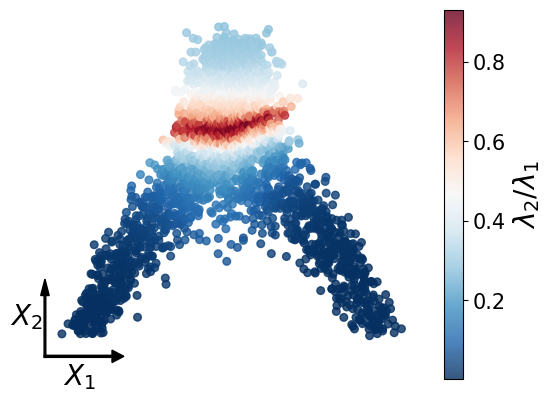

In [30]:
plt.scatter(X_plt,Y_plt,c=smooth_func(max2_fs/max_fs),s=30,alpha=0.8,cmap='RdBu_r')
plt.axis('off')

plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=6*wid,head_length=7*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid,head_length=8*wid)
plt.text(X_ori+X_len/2,Y_ori-wid*14,'$X_1$',fontsize=20,ha='center',weight='bold')
plt.text(X_ori-wid*11,Y_ori+Y_len/2,'$X_2$',fontsize=20,ha='center',weight='bold')

clb = plt.colorbar()
clb.ax.set_ylabel('$\lambda_2/\lambda_1$',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)
#plt.savefig(figure_path+'bifur_ratio_new.png',dpi=600,bbox_inches='tight')

plt.show()

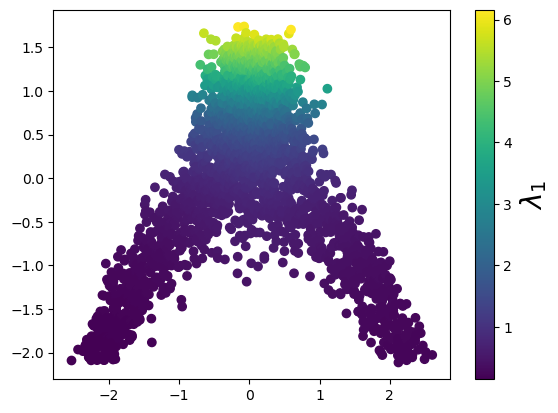

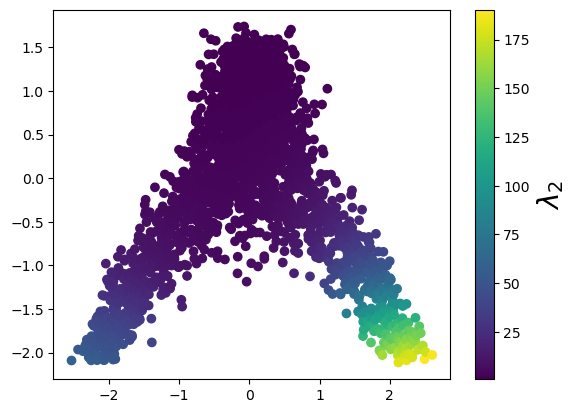

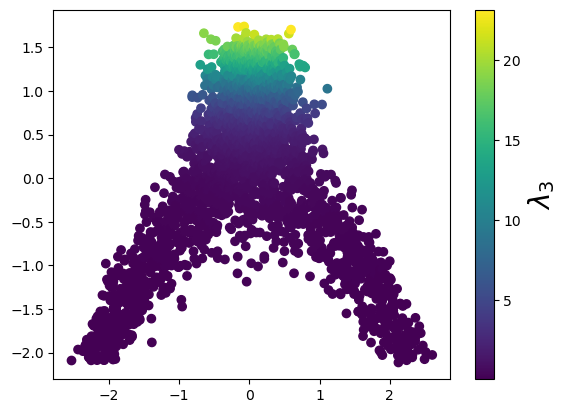

In [31]:
plt.scatter(X_plt,Y_plt,c=Fisher_g[:,0,0])
clb=plt.colorbar()
clb.ax.set_ylabel('$\lambda_1$',fontsize=20,weight='bold')
plt.show()

plt.scatter(X_plt,Y_plt,c=Fisher_g[:,2,2])
clb=plt.colorbar()
clb.ax.set_ylabel('$\lambda_2$',fontsize=20,weight='bold')
plt.show()

plt.scatter(X_plt,Y_plt,c=Fisher_g[:,4,4])
clb=plt.colorbar()
clb.ax.set_ylabel('$\lambda_3$',fontsize=20,weight='bold')
plt.show()

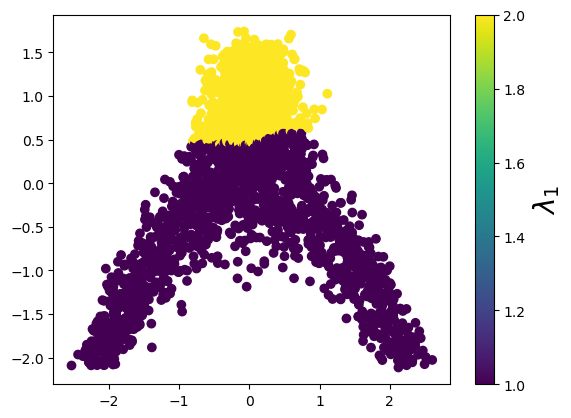

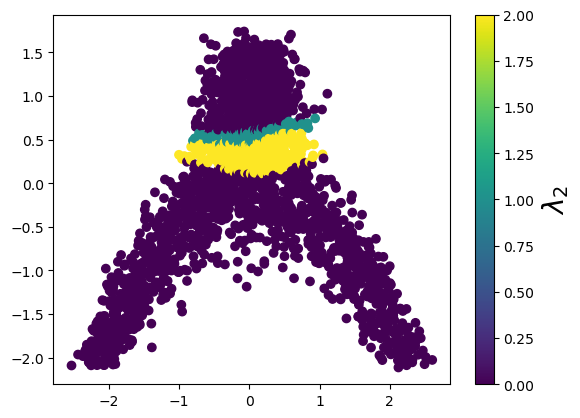

In [32]:
plt.scatter(X_plt,Y_plt,c=max_label)
clb=plt.colorbar()
clb.ax.set_ylabel('$\lambda_1$',fontsize=20,weight='bold')
plt.show()

plt.scatter(X_plt,Y_plt,c=max2_label)
clb=plt.colorbar()
clb.ax.set_ylabel('$\lambda_2$',fontsize=20,weight='bold')
plt.show()